# Logistic regression

## read data

注意事项：

1）跳过第一行，第一行是列名

2）跳过第一列，第一列是序号

3）读数据时，赋予dtype，不然默认会是str

In [2]:
import numpy as np

In [3]:
X_train_path = '../DATA/hw2/data/X_train'
y_train_path = '../DATA/hw2/data/Y_train'
X_test_path = '../DATA/hw2/data/X_test'

In [10]:
with open(X_train_path) as f:
    #跳过第一行，第一行是列名。
    next(f)
    X_train = np.array([line.strip('\n').split(',')[1:] for line in f], dtype=float)

with open(y_train_path) as f:
    next(f)
    Y_train = np.array([line.strip('\n').split(',')[1] for line in f], dtype=float)

with open(X_test_path) as f:
    next(f)
    X_test = np.array([line.strip('\n').split(',')[1:] for line in f], dtype=float)

In [4]:
X_train.shape, Y_train.shape,X_test.shape

((54256, 510), (54256,), (27622, 510))

## Normalization

注意事项：

1） np.mean(x, 0), 0代表对每列求，1代表对每行

2） 测试集，用和train一样的mean和std

3） 因为logistic regression输入X 还是回归形式，如果是类别0、1的话，会使得w\*x直接变成0，所以对类别标签也要做norm，使其变为连续型

In [5]:
def normalization(X_train, train=True, specified_column=None, X_mean=None, X_std=None):
    X = X_train.copy()
    if specified_column == None:
        specified_column = np.arange(X.shape[1])
    if train:
        X_mean = np.mean(X[:,specified_column], 0).reshape(1, -1)
        X_std = np.std(X[:, specified_column], 0).reshape(1, -1)
    
    X[:,specified_column] = (X[:, specified_column] - X_mean) / (X_std + 1e-8)

    return X, X_mean, X_std


In [11]:
X_train_norm, X_mean, X_std = normalization(X_train, train=True)
X_test_norm, _, _ = normalization(X_test, train=False, X_mean=X_mean, X_std=X_std)

## split data

注意事项：

1）先对数据进行normalization后，再把trainsplit成train和val

In [14]:
def train_test_split(X, Y, val_ratio=0.25):
    train_size = int(len(X) * (1 - val_ratio))
    return X[:train_size], Y[:train_size], X[train_size:], Y[train_size:]

In [15]:
val_ratio = 0.1
X_train, Y_train, X_val, Y_val = train_test_split(X_train_norm, Y_train, val_ratio)

# train的行数，即训练集样本数
train_size = X_train.shape[0]
# val的行数，即验证集样本数
val_size = X_val.shape[0]
# test的行数，即测试集输出行数
test_size = X_test.shape[0]
# 列数，即属性数
data_dim = X_train.shape[1]

print(train_size, val_size, test_size, data_dim)

48830 5426 27622 510


## Some Useful Function

注意事项：

1）求sigmoid的时候，clip限制最小和最大值

2）predict时，round把0-1间的数，转换为更贴近它的整数

In [8]:
def shuffle(X, Y):
    # this function shuffles two equal-length list, X and Y, together
    # 得到行号
    randomize = np.arange(len(X))
    # 把行号打乱
    np.random.shuffle(randomize)
    # 应用到X和y上去
    return X[randomize], Y[randomize]

# clip限制最小和最大值
def sigmoid(z):
    return np.clip(1/(1.0+np.exp(-z)), 1e-8, 1-(1e-8))

def f(X, w, b):
    return sigmoid(np.matmul(X, w) + b)

# round把0-1间的数，转换为更贴近它的整数
def predict(X, w, b):
    return np.round(f(X, w, b)).astype(np.int)

def accuracy(Y_pred, Y_label):
    acc = 1 - np.mean(np.abs(Y_pred - Y_label))
    return acc

## Gradient and loss Functions

注意事项：

1） np.dot 和 np.matmul的区别：

matmul、dot、@是矩阵乘 叉乘

multiply、\* 、∙ 是每位乘 点乘

dot是两者结合

* 当a, b 都是一维时，dot与matmul相同 = a1b1 + a2b2 + .. + anbn
* 当a, b 都是二维时，dot与matmul相同 
a = 3x2, b = 2x3, dot(a, b) = 3x2 x 2x3 = 3x3
* 当a, b 中有一个标量时，dot等价于multiply或*
a = 2x3, b = const = 3, dot(a, b) = multiply(a, b) = axb = a中每位元素都乘以b

In [17]:
Y_train.shape

(48830,)

In [41]:
def cross_entropy_loss(Y_pred, Y_label):
    cross_entropy = -(np.matmul(Y_label, np.log(Y_pred)) + np.matmul(1 - Y_label, np.log(1 - Y_pred)))
    return cross_entropy

def gradient(X, Y_label, w, b):
    Y_pred = f(X, w, b)
    pred_error = Y_label - Y_pred
    w_grad = -np.sum(pred_error * X.T, 1)
    b_grad = -np.sum(pred_error)
    
    #print('hello:',pred_error.shape, X.T.shape, w_grad.shape, b_grad.shape)
    
    return w_grad, b_grad

## Training

注意事项：

1）每次训练前，记得shuffle数据

In [39]:
import matplotlib.pyplot as plt

def train(max_iter=10, batch_size=8, learning_rate=0.2, X_train=X_train, Y_train=Y_train, X_val=X_val, Y_val=Y_val):
    #初始化weights and bias
    w = np.zeros((data_dim, ))
    b = np.zeros((1, ))

    # training parameters
    max_iter = max_iter
    batch_size = batch_size
    learning_rate = learning_rate

    # keep the loss and accuracy at every iteration for plotting
    train_loss = []
    val_loss = []
    train_acc = []
    val_acc = []

    # calculate the number of parameters updates
    step = 1

    # iterative training
    for epoch in range(max_iter):
        # random shuffle at the begining of each epoch
        X_train, Y_train = shuffle(X_train, Y_train)

        # mini_batch training
        for idx in range(int(np.floor(train_size/batch_size))):
            X = X_train[idx*batch_size:(idx+1)*batch_size]
            Y = Y_train[idx*batch_size:(idx+1)*batch_size]

            # compute gradient
            w_grad, b_grad = gradient(X, Y, w, b)

            # gradient descent update
            # learning rate decay with time
            w = w - learning_rate/np.sqrt(step) * w_grad
            b = b - learning_rate/np.sqrt(step) * b_grad

            step += 1

        # compute loss and acc of training set and validation set
        y_train_pred = f(X_train, w, b)
        Y_train_pred = np.round(y_train_pred)

        train_acc.append(accuracy(Y_train_pred, Y_train))
        train_loss.append(cross_entropy_loss(y_train_pred, Y_train) / train_size)

        y_val_pred = f(X_val, w, b)
        Y_val_pred = np.round(y_val_pred)

        val_acc.append(accuracy(Y_val_pred, Y_val))
        val_loss.append(cross_entropy_loss(y_val_pred, Y_val) / val_size)

    print('Training loss:', train_loss[-1])
    print('Validation loss:', val_loss[-1])
    print('Training acc:', train_acc[-1])
    print('Validation acc:', val_acc[-1])
    
    # plot
    # loss curve
    plt.plot(train_loss)
    plt.plot(val_loss)
    plt.title('Loss')
    plt.legend(['train', 'val'])
    plt.show()
    # acc curve
    plt.plot(train_acc)
    plt.plot(val_acc)
    plt.title('Accuracy')
    plt.legend(['train', 'val'])
    plt.show()
    
    return 

Training loss: 0.2745019664333751
Validation loss: 0.291785840108575
Training acc: 0.8839238173254147
Validation acc: 0.8743088831551787


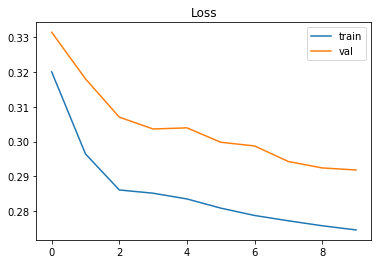

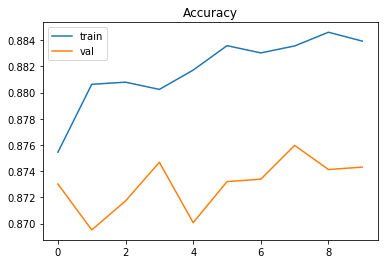

In [42]:
train(max_iter=10, batch_size=8, learning_rate=0.2)

Training loss: 0.26562922241566533
Validation loss: 0.2895375456771115
Training acc: 0.8844562768789679
Validation acc: 0.8763361592333211


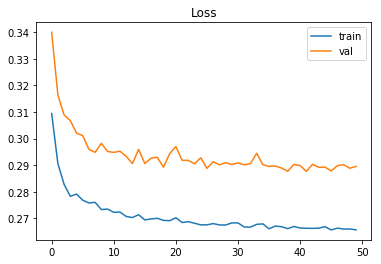

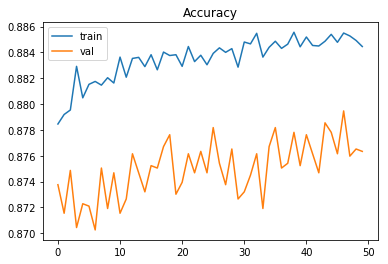

In [43]:
train(max_iter=50, batch_size=50, learning_rate=0.1)

Training loss: 0.2639107107548517
Validation loss: 0.2877901302885699
Training acc: 0.8859922178988326
Validation acc: 0.8772576483597494


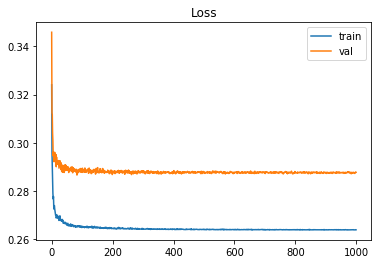

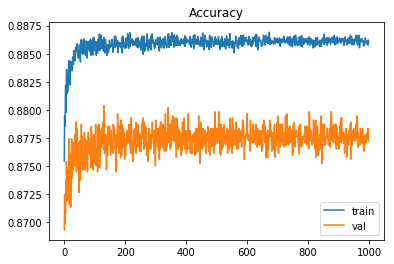

In [44]:
train(max_iter=1000, batch_size=50, learning_rate=0.1)

## plotting

一起写在train函数中了

# Probabilistic generative model

In [6]:
with open(X_train_path) as f:
    #跳过第一行，第一行是列名。
    next(f)
    X_train = np.array([line.strip('\n').split(',')[1:] for line in f], dtype=float)

with open(y_train_path) as f:
    next(f)
    Y_train = np.array([line.strip('\n').split(',')[1] for line in f], dtype=float)

with open(X_test_path) as f:
    next(f)
    X_test = np.array([line.strip('\n').split(',')[1:] for line in f], dtype=float)

    
# Normalize training and testing data
X_train, X_mean, X_std = normalization(X_train, train = True)
X_test, _, _= normalization(X_test, train = False, specified_column = None, X_mean = X_mean, X_std = X_std)

## mean and covariance

在generative model中，我们需要分别计算两个类别内的mean和cov

In [7]:
# compute in-class mean
X_train_0 = np.array([x for x,y in zip(X_train, Y_train) if y==0])
X_train_1 = np.array([x for x,y in zip(X_train, Y_train) if y==1])

mean_0 = np.mean(X_train_0, axis=0)
mean_1 = np.mean(X_train_1, axis=0)

# compute in-class convariance
data_dim = 510 #compute by previous method
conv_0 = np.zeros((data_dim, data_dim))
conv_1 = np.zeros((data_dim, data_dim))

for x in X_train_0:
    conv_0 += np.dot(np.transpose([x-mean_0]), [x-mean_0])/X_train_0.shape[0]
    conv_1 += np.dot(np.transpose([x-mean_1]), [x-mean_1])/X_train_1.shape[0]
    
# shared covariance is taken as a weighted average of individual in-class varaince
conv = (conv_0 * X_train_0.shape[0] + conv_1 * X_train_1.shape[0]) / (X_train_0.shape[0]+X_train_1.shape[0])


## computing weights and bias

Directly compute weights and bias from in-class mean and shared variance.

In [9]:
# compute inverse of convariance matrix
# since convariance matrix may be nearly singular, np.linalg.inv() 
# may give a large numerical error.
# via SVD decomposiion, one can get matrix inverse efficiently and
# accurately.

u, s, v = np.linalg.svd(conv, full_matrices=False)
inv = np.matmul(v.T*1/s, u.T)

# directly compute weights and bias
w = np.dot(inv, mean_0 - mean_1)
b = -0.5*np.dot(mean_0, np.dot(inv, mean_0)) + 0.5*np.dot(mean_1, np.dot(inv, mean_1))+np.log(float(X_train_0.shape[0])/X_train_1.shape[0])

# compute accuracy on training set
Y_train_pred = 1 - predict(X_train, w, b)
acc = accuracy(Y_train_pred, Y_train)
print("Training accuracy:", acc)

Training accuracy: 0.8231163373636096


In [11]:
# predict testing labels
predictions = 1 - predict(X_test, w, b)
with open(output_fpath.format('generative'), 'w') as f:
    f.write('id, label\n')
    for i, label in enumerate(predictions):
        f.write('{},{}\n'.format(i, label))

# print out the most significant weights
ind = np.argsort(np.abs(w))[::-1]
with open(X_test_fpath) as f:
    content = f.readline().strip('\n').split(',')
features = np.array(content)
for i in ind[0:10]:
    print(features[i], w[i])

NameError: name 'output_fpath' is not defined

## 思考

generative 和 logistic regression 哪种更好？为什么？

logistic加上正则化后，会怎么样？不同lambda会有什么样的影响？

regulatization可参考：https://goo.gl/SSWGhf p.35!

如果logistic没有做normalization会怎么样？